In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Unzip the input file
input_file = '/content/drive/MyDrive/ColabNotebooks_/Lab-7/HippocampusMR.zip'  # TODO: Update with the actual path to the zip file
output_folder = '/content/drive/MyDrive/ColabNotebooks_/Lab-7/' # TODO: Update with the actual path to the output folder

!unzip $input_file -d $output_folder


Archive:  /content/drive/MyDrive/ColabNotebooks_/Lab-7/HippocampusMR.zip
replace /content/drive/MyDrive/ColabNotebooks_/Lab-7/HippocampusMR/imagesTr/HippocampusMR_0037_0000.nii.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

output_folder_1 = '/content/drive/MyDrive/ColabNotebooks_/Lab-7/HippocampusMR/'
dataset_path = output_folder_1
dataset_csv_path = os.path.join(dataset_path, "dataset.csv")
training_csv_path = os.path.join(dataset_path, "dataset_training.csv")
validation_csv_path = os.path.join(dataset_path, "dataset_validation.csv")
testing_csv_path = os.path.join(dataset_path, "dataset_testing.csv")

image_dir = os.path.join(dataset_path, 'imagesTr')
label_dir = os.path.join(dataset_path, 'labelsTr')

data = []

for image_filename in os.listdir(image_dir):
    image_path = os.path.join('imagesTr', image_filename)
    label_filename = image_filename.replace('.jpg', '_label.jpg')
    label_path = os.path.join('labelsTr', label_filename)

    data.append({'Image_Path': image_path, 'Label_Path': label_path})

dataframe = pd.DataFrame(data)

split_ratio = (0.7, 0.1, 0.2)
train_size = split_ratio[0]
val_size = split_ratio[1]
test_size = split_ratio[2]

val_test_size = val_size + test_size
val_relative_size = val_size / val_test_size

training_dataframe, temp_dataframe = train_test_split(dataframe, test_size=val_test_size, random_state=42)
validation_dataframe, testing_dataframe = train_test_split(temp_dataframe, test_size=1 - val_relative_size, random_state=42)

dataframe.to_csv(dataset_csv_path, index=False)
training_dataframe.to_csv(training_csv_path, index=False)
validation_dataframe.to_csv(validation_csv_path, index=False)
testing_dataframe.to_csv(testing_csv_path, index=False)

print(f"Number of cases: {len(dataframe)}")
print(f"Number of training cases: {len(training_dataframe)}")
print(f"Number of validation cases: {len(validation_dataframe)}")
print(f"Number of testing cases: {len(testing_dataframe)}")


Number of cases: 261
Number of training cases: 182
Number of validation cases: 26
Number of testing cases: 53


In [5]:
import os
import pandas as pd

def create_pairs(dataframe):
    pairs = []
    for index, row in dataframe.iterrows():
        source_image = row['Image_Path']
        source_label = row['Label_Path']
        for index2, row2 in dataframe.iterrows():
            if index != index2:
                target_image = row2['Image_Path']
                target_label = row2['Label_Path']
                pairs.append({'Source_Path': source_image,
                              'Target_Path': target_image,
                              'Source_Label_Path': source_label,
                              'Target_Label_Path': target_label})
    processed_dataframe = pd.DataFrame(pairs)
    return processed_dataframe

processed_training_dataframe = create_pairs(training_dataframe)
processed_validation_dataframe = create_pairs(validation_dataframe)
processed_testing_dataframe = create_pairs(testing_dataframe)

print(f"Number of training pairs: {len(processed_training_dataframe)}")
print(f"Number of validation pairs: {len(processed_validation_dataframe)}")
print(f"Number of testing pairs: {len(processed_testing_dataframe)}")

processed_training_csv_path = os.path.join(dataset_path, "processed_dataset_training.csv")
processed_validation_csv_path = os.path.join(dataset_path, "processed_dataset_validation.csv")
processed_testing_csv_path = os.path.join(dataset_path, "processed_dataset_testing.csv")

processed_training_dataframe.to_csv(processed_training_csv_path, index=False)
processed_validation_dataframe.to_csv(processed_validation_csv_path, index=False)
processed_testing_dataframe.to_csv(processed_testing_csv_path, index=False)


Number of training pairs: 32942
Number of validation pairs: 650
Number of testing pairs: 2756


In [6]:
import torch
import torch.utils.data as tcdata
import pandas as pd
import nibabel as nib
import numpy as np

class MRRegistrationDataset(tcdata.Dataset):
    def __init__(self, images_path, labels_path, csv_path):
        self.images_path = images_path
        self.labels_path = labels_path
        self.dataframe = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        current_case = self.dataframe.iloc[idx]
        source_image_path = os.path.join(self.images_path, current_case['Source_Path'])
        target_image_path = os.path.join(self.images_path, current_case['Target_Path'])
        source_label_path = os.path.join(self.labels_path, current_case['Source_Label_Path'])
        target_label_path = os.path.join(self.labels_path, current_case['Target_Label_Path'])

        source_image = nib.load(source_image_path).get_fdata()
        target_image = nib.load(target_image_path).get_fdata()
        source_label = nib.load(source_label_path).get_fdata()
        target_label = nib.load(target_label_path).get_fdata()

        source_image = torch.tensor(source_image).unsqueeze(0)
        target_image = torch.tensor(target_image).unsqueeze(0)
        source_label = torch.tensor(source_label).unsqueeze(0)
        target_label = torch.tensor(target_label).unsqueeze(0)

        source_mask = torch.where(source_label > 0, torch.tensor(1), torch.tensor(0))
        target_mask = torch.where(target_label > 0, torch.tensor(1), torch.tensor(0))

        return source_image, target_image, source_mask, target_mask


Dataset size: 2756
Batch shape: torch.Size([2, 1, 64, 64, 64])
Sources min/max: (tensor(0., dtype=torch.float64), tensor(1702.1488, dtype=torch.float64))
Targets min/max: (tensor(0., dtype=torch.float64), tensor(2510.9287, dtype=torch.float64))
Sources_masks min/max: (tensor(0), tensor(1))
Targets_masks min/max: (tensor(0), tensor(1))


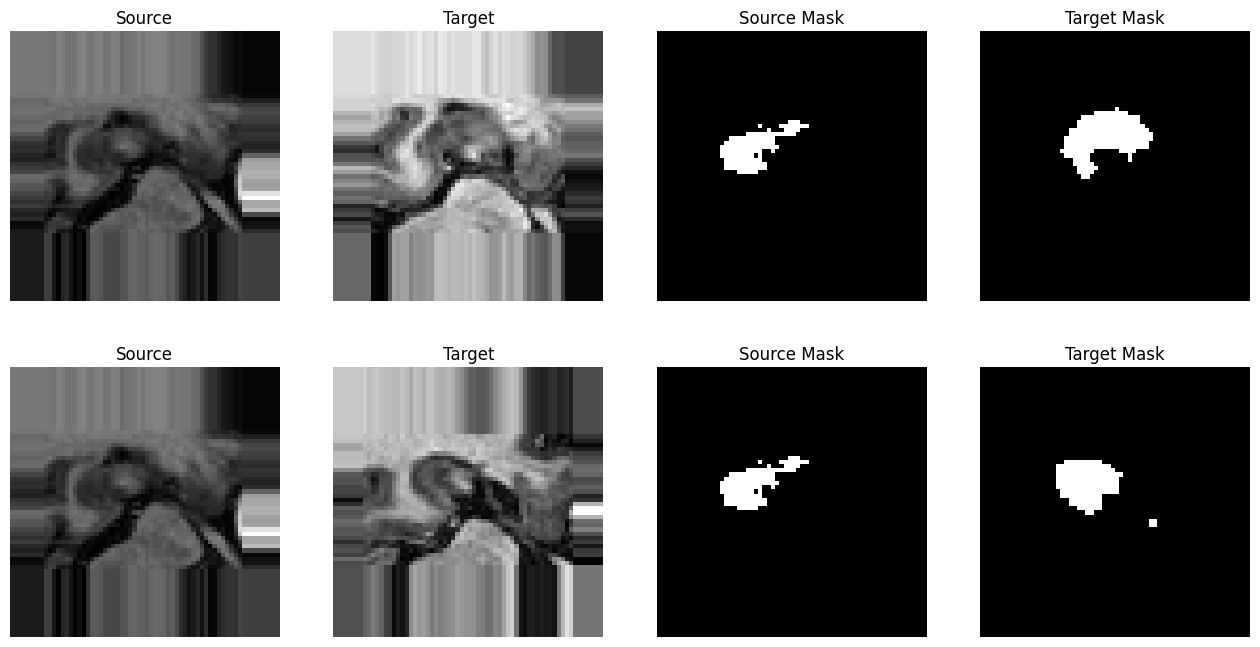

In [7]:
import matplotlib.pyplot as plt

images_path = os.path.join(dataset_path, "imagesTr")
labels_path = os.path.join(dataset_path, "labelsTr")
testing_dataset = MRRegistrationDataset(images_path, labels_path, processed_testing_csv_path)

batch_size = 2
print(f"Dataset size: {len(testing_dataset)}")
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

for sources, targets, sources_masks, targets_masks in testing_dataloader:
    rows = batch_size
    cols = 4
    print(f"Batch shape: {sources.size()}")
    print(f"Sources min/max: {sources.min(), sources.max()}")
    print(f"Targets min/max: {targets.min(), targets.max()}")
    print(f"Sources_masks min/max: {sources_masks.min(), sources_masks.max()}")
    print(f"Targets_masks min/max: {targets_masks.min(), targets_masks.max()}")

    inputs = torch.cat((sources, targets), dim=1)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))

    for i in range(rows):
        source_image = sources[i, 0, :, :, sources.shape[4] // 2]
        target_image = targets[i, 0, :, :, targets.shape[4] // 2]
        source_label = sources_masks[i, 0, :, :, sources_masks.shape[4] // 2]
        target_label = targets_masks[i, 0, :, :, targets_masks.shape[4] // 2]

        axes[i, 0].imshow(source_image, cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title("Source")

        axes[i, 1].imshow(target_image, cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title("Target")

        axes[i, 2].imshow(source_label, cmap='gray')
        axes[i, 2].axis('off')
        axes[i, 2].set_title("Source Mask")

        axes[i, 3].imshow(target_label, cmap='gray')
        axes[i, 3].axis('off')
        axes[i, 3].set_title("Target Mask")

    plt.show()
    break


In [42]:
import torch as tc

class RegUNet(tc.nn.Module):
    def __init__(self):
        super(RegUNet, self).__init__()
        self.conv1 = tc.nn.Conv3d(2, 16, kernel_size=3, padding=1).cuda().double()
        self.conv2 = tc.nn.Conv3d(16, 32, kernel_size=3, padding=1).cuda().double()
        self.conv3 = tc.nn.Conv3d(32, 64, kernel_size=3, padding=1).cuda().double()
        self.conv4 = tc.nn.Conv3d(64, 64, kernel_size=3, padding=1).cuda().double()
        self.upconv1 = tc.nn.ConvTranspose3d(64, 64, kernel_size=2, stride=2).cuda().double()
        self.upconv2 = tc.nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2).cuda().double()
        self.upconv3 = tc.nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2).cuda().double()
        self.upconv4 = tc.nn.ConvTranspose3d(16, 3, kernel_size=2, stride=2).cuda().double()

    def forward(self, x):
        x = tc.nn.functional.relu(self.conv1(x))
        x1 = x
        x = tc.nn.functional.max_pool3d(x, 2, 2)
        x = tc.nn.functional.relu(self.conv2(x))
        x2 = x
        x = tc.nn.functional.max_pool3d(x, 2, 2)
        x = tc.nn.functional.relu(self.conv3(x))
        x3 = x
        x = tc.nn.functional.max_pool3d(x, 2, 2)
        x = tc.nn.functional.relu(self.conv4(x))
        x = tc.nn.functional.relu(self.upconv1(x))
        x = x + x3
        x = tc.nn.functional.relu(self.upconv2(x))
        x = x + x2
        x = tc.nn.functional.relu(self.upconv3(x))
        x = x + x1
        x = self.upconv4(x)
        return x

# Testing the network
model = RegUNet()
input_tensor = tc.randn(1, 2, 64, 64, 64).cuda().double()
output = model(input_tensor)
print("Output shape:", output.shape)


Output shape: torch.Size([1, 3, 128, 128, 128])


In [43]:
def generate_grid(tensor_size: tc.Tensor, device="cpu"):
    """
    Utility function to generate an identity transform.
    """
    identity_transform = tc.eye(len(tensor_size)-1, device=device)[:-1, :].unsqueeze(0)
    identity_transform = tc.repeat_interleave(identity_transform, tensor_size[0], dim=0)
    grid = F.affine_grid(identity_transform, tensor_size, align_corners=False)
    return grid

def warp_tensor(tensor: tc.Tensor, displacement_field: tc.Tensor, grid: tc.Tensor=None, device: str="cpu", mode: str='bilinear'):
    """
    Utility function to warp the tensors.
    """
    if grid is None:
        grid = generate_grid(tensor.size(), device=device)
    sampling_grid = grid + displacement_field
    transformed_tensor = F.grid_sample(tensor, sampling_grid, mode=mode, padding_mode='zeros', align_corners=False)
    return transformed_tensor

def ncc_local_tc(sources: tc.Tensor, targets: tc.Tensor, device: str="cpu", **params):
    """
    Local normalized cross correlation.
    """
    ndim = len(sources.size()) - 2
    if ndim not in [2, 3]:
        raise ValueError("Unsupported number of dimensions.")
    try:
        win_size = params['win_size']
    except:
        win_size = 3
    window = (win_size, ) * ndim
    sum_filt = tc.ones([1, 1, *window]).to(device)
    pad_no = math.floor(window[0] / 2)
    stride = ndim * (1,)
    padding = ndim * (pad_no,)
    conv_fn = getattr(F, 'conv%dd' % ndim)
    sources_denom = sources**2
    targets_denom = targets**2
    numerator = sources*targets
    sources_sum = conv_fn(sources, sum_filt, stride=stride, padding=padding)
    targets_sum = conv_fn(targets, sum_filt, stride=stride, padding=padding)
    sources_denom_sum = conv_fn(sources_denom, sum_filt, stride=stride, padding=padding)
    targets_denom_sum = conv_fn(targets_denom, sum_filt, stride=stride, padding=padding)
    numerator_sum = conv_fn(numerator, sum_filt, stride=stride, padding=padding)
    size = np.prod(window)
    u_sources = sources_sum / size
    u_targets = targets_sum / size
    cross = numerator_sum - u_targets * sources_sum - u_sources * targets_sum + u_sources * u_targets * size
    sources_var = sources_denom_sum - 2 * u_sources * sources_sum + u_sources * u_sources * size
    targets_var = targets_denom_sum - 2 * u_targets * targets_sum + u_targets * u_targets * size
    ncc = cross * cross / (sources_var * targets_var + 1e-5)
    return -tc.mean(ncc)

def diffusion_tc(displacement_field: tc.Tensor, device: str="cpu", **params):
    """
    Diffusive regularization.
    """
    ndim = len(displacement_field.size()) - 2
    if ndim == 3:
        dx = (displacement_field[:, 1:, :, :, :] - displacement_field[:, :-1, :, :, :])**2
        dy = (displacement_field[:, :, 1:, :, :] - displacement_field[:, :, :-1, :, :])**2
        dz = (displacement_field[:, :, :, 1:, :] - displacement_field[:, :, :, :-1, :])**2
        diffusion_reg = (tc.mean(dx) + tc.mean(dy) + tc.mean(dz)) / 3
    else:
        raise ValueError("Unsupported number of dimensions.")
    return diffusion_reg

In [44]:
import torch as tc
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

def training(model, training_dataloader, validation_dataloader,
             disimilarity_function, regularization_function, regularization_coefficient,
             optimizer, num_epochs, logger, device):

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        for sources, targets, sources_masks, targets_masks in training_dataloader:
            sources, targets, sources_masks, targets_masks = sources.to(device), targets.to(device), sources_masks.to(device), targets_masks.to(device)

            displacement_fields = model(tc.cat((sources, targets), dim=1))
            similarity_loss = disimilarity_function(sources, warp_tensor(targets, displacement_fields, device=device))
            regularization_loss = regularization_coefficient * regularization_function(displacement_fields)
            loss = similarity_loss + regularization_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * sources.size(0)

        training_loss = total_loss / len(training_dataloader.dataset)

        model.eval()
        total_val_loss = 0.0
        with tc.no_grad():
            for sources, targets, sources_masks, targets_masks in validation_dataloader:
                sources, targets, sources_masks, targets_masks = sources.to(device), targets.to(device), sources_masks.to(device), targets_masks.to(device)

                displacement_fields = model(tc.cat((sources, targets), dim=1))

                similarity_loss = disimilarity_function(sources, warp_tensor(targets, displacement_fields, device=device))
                regularization_loss = regularization_coefficient * regularization_function(displacement_fields)
                loss = similarity_loss + regularization_loss

                total_val_loss += loss.item() * sources.size(0)

        validation_loss = total_val_loss / len(validation_dataloader.dataset)

        logger.info(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {training_loss}, Validation Loss: {validation_loss}')

    logger.info('Training completed.')


In [45]:
learning_rate = 0.003
model = RegUNet()
batch_size = 16
num_epochs = 150
parameters = model.parameters()
optimizer = tc.optim.Adam(parameters, lr=learning_rate)
device = "cuda:0"
logger = SummaryWriter(log_dir=os.path.join(dataset_path, "logs"), comment="RegUNet")
disimilarity_function = ncc_local_tc
regularization_function = diffusion_tc
regularization_coefficient = 3500


training_dataset = MRRegistrationDataset(images_path, labels_path, processed_training_csv_path)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = MRRegistrationDataset(images_path, labels_path, processed_validation_csv_path)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [46]:

log_dir = "./logs"
logger = SummaryWriter(log_dir=log_dir)
